In [1]:
## tutorial: https://stereopy.readthedocs.io/en/latest/Tutorials/clustering.html#
import stereo as st
import os
import re

os.chdir('/scratch/u/qqiu/project/multiomics/stereo_seq/result/')

2023-03-01 13:23:38.189104: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gef = '849BL_A4/04.tissuecut/SS200000849BL_A4.tissue.gef'
#st.io.read_gef_info(E4_gef)

In [3]:
data = st.io.read_gef(file_path=gef, bin_size=50)
adata = st.io.stereo_to_anndata(data, flavor='seurat', output='849BL_A4.bin50.h5ad')

[2023-03-01 13:23:51][Stereo][4822][140238747371328][reader][518][INFO]: read_gef begin ...
[2023-03-01 13:23:54][Stereo][4822][140238747371328][reader][591][INFO]: the matrix has 31423 cells, and 15965 genes.
[2023-03-01 13:23:54][Stereo][4822][140238747371328][reader][599][INFO]: read_gef end.
[2023-03-01 13:23:54][Stereo][4822][140238747371328][reader][324][INFO]: Adding sample in adata.obs['orig.ident'].
[2023-03-01 13:23:54][Stereo][4822][140238747371328][reader][327][INFO]: Adding data.position as adata.obsm['spatial'] .
[2023-03-01 13:23:54][Stereo][4822][140238747371328][reader][330][INFO]: Adding data.position as adata.obs['x'] and adata.obs['y'] .
[2023-03-01 13:23:54][Stereo][4822][140238747371328][reader][416][INFO]: Rename QC info.
[2023-03-01 13:23:54][Stereo][4822][140238747371328][reader][432][INFO]: Finished conversion to anndata.
[2023-03-01 13:23:54][Stereo][4822][140238747371328][reader][436][INFO]: Finished output to 849BL_A4.bin50.h5ad


In [4]:
adata.write_csvs("849BL_A4.obs", skip_data=False)

writing .csv files to 849BL_A4.obs


In [4]:
import anndata
import numpy as np
import pandas as pd

ann_data = anndata.read('849BL_A4.bin50.h5ad')
arr = np.array(ann_data.obs.index.str.split('_').to_list(), dtype=np.uint32)
ann_data.obs['x'] = pd.Series(arr[:, 0], index=ann_data.obs.index)
ann_data.obs['y'] = pd.Series(arr[:, 1], index=ann_data.obs.index)
ann_data.write_h5ad('849BL_A4.bin50.h5ad')

IndexError: index 1 is out of bounds for axis 1 with size 1

[2023-01-31 13:43:45][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run cal_qc...
[2023-01-31 13:43:45][Stereo][137620][140387773699904][st_pipeline][43][INFO]: cal_qc end, consume time 0.0439s.


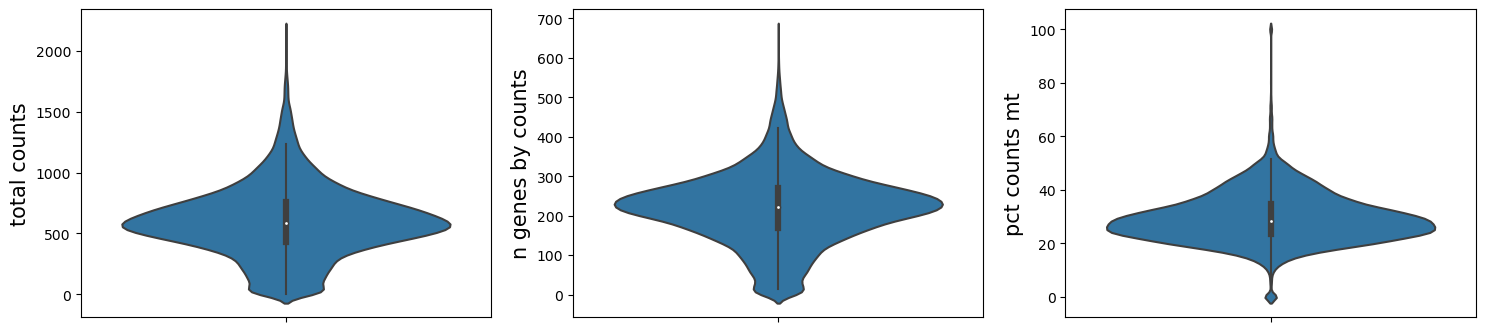

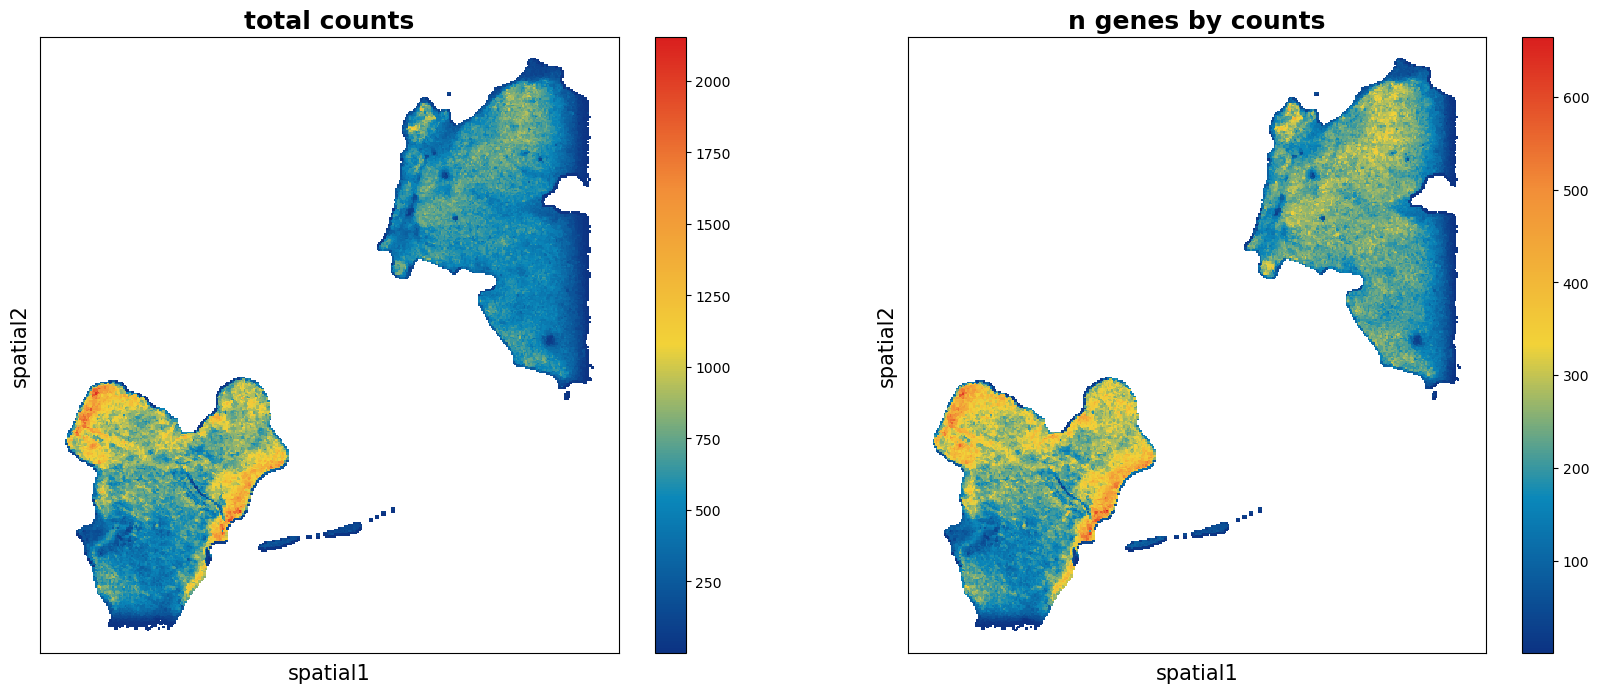

In [19]:
## quality control
data.tl.cal_qc()
data.plt.violin()
data.plt.spatial_scatter()

In [20]:
pattern = re.compile(r'^Rp[Sl]\d+|^Ig|^[Mm]t-')
black_gene_list = [i for i in data.gene_names if pattern.search(i)]
remain_gene_list = [i for i in data.gene_names if i not in black_gene_list]
len(remain_gene_list)

15872

In [21]:
## filtering
data.tl.filter_cells(min_gene=50, min_n_genes_by_counts=3, pct_counts_mt=60, inplace=True)
data.tl.filter_genes(min_cell=3, gene_list=remain_gene_list, inplace=True)
data.exp_matrix.shape

[2023-01-31 13:43:46][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run filter_cells...
[2023-01-31 13:43:46][Stereo][137620][140387773699904][st_pipeline][43][INFO]: filter_cells end, consume time 0.0439s.
[2023-01-31 13:43:46][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run filter_genes...
[2023-01-31 13:43:47][Stereo][137620][140387773699904][st_pipeline][43][INFO]: filter_genes end, consume time 0.0805s.


(30396, 14326)

In [22]:
## normalization
data.tl.raw_checkpoint() # save raw exp_matrix

#data.tl.sctransform(n_genes=2000, res_key="sct")
#data.tl.highly_variable_genes(min_mean=0.0125, max_mean=3,min_disp=0.5,
#                              n_top_genes=2000, res_key='hvg_sct')
#data.plt.highly_variable_genes(res_key='hvg_sct')

[2023-01-31 13:43:49][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run normalize_total...
[2023-01-31 13:43:49][Stereo][137620][140387773699904][st_pipeline][43][INFO]: normalize_total end, consume time 0.0631s.
[2023-01-31 13:43:49][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run log1p...
[2023-01-31 13:43:49][Stereo][137620][140387773699904][st_pipeline][43][INFO]: log1p end, consume time 0.0162s.
[2023-01-31 13:43:49][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run highly_variable_genes...
[2023-01-31 13:43:50][Stereo][137620][140387773699904][st_pipeline][43][INFO]: highly_variable_genes end, consume time 0.6162s.


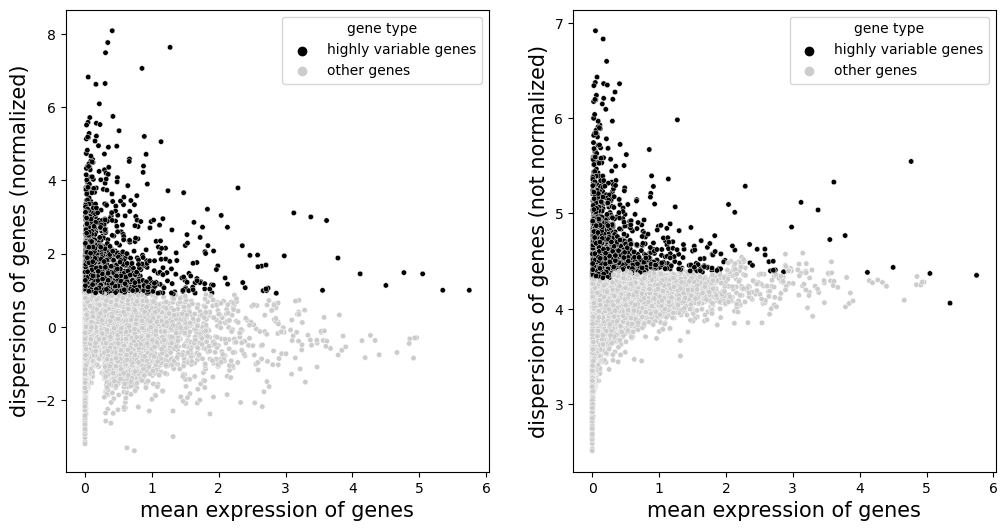

In [23]:
data.tl.normalize_total(target_sum=10000, res_key="nt")
data.tl.log1p(res_key="log1p")

data.tl.highly_variable_genes(min_mean=0.0125, max_mean=3,min_disp=0.5,
                              n_top_genes=2000, res_key='hvg_nt')
data.plt.highly_variable_genes(res_key='hvg_nt')

In [24]:
data.tl.scale(max_value=10, zero_center=True)
data.tl.pca(use_highly_genes=True, n_pcs=20, res_key='pca', hvg_res_key="hvg_nt")
data.tl.neighbors(pca_res_key='pca', n_pcs=20, res_key='neighbors', n_jobs=6)
data.tl.umap(pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap')

[2023-01-31 13:43:50][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run scale...
[2023-01-31 13:43:53][Stereo][137620][140387773699904][scale][52][INFO]: Truncate at max_value 10
[2023-01-31 13:43:53][Stereo][137620][140387773699904][st_pipeline][43][INFO]: scale end, consume time 2.9838s.
[2023-01-31 13:43:53][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run pca...
[2023-01-31 13:43:55][Stereo][137620][140387773699904][st_pipeline][43][INFO]: pca end, consume time 1.9843s.
[2023-01-31 13:43:55][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run neighbors...
[2023-01-31 13:43:57][Stereo][137620][140387773699904][st_pipeline][43][INFO]: neighbors end, consume time 1.9637s.
[2023-01-31 13:43:57][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run umap...


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


[2023-01-31 13:44:08][Stereo][137620][140387773699904][st_pipeline][43][INFO]: umap end, consume time 10.5457s.


[2023-01-31 13:44:08][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run louvain...
[2023-01-31 13:44:08][Stereo][137620][140387773699904][_louvain][99][INFO]:     using the "louvain" package of Traag (2017)
[2023-01-31 13:44:10][Stereo][137620][140387773699904][st_pipeline][43][INFO]: louvain end, consume time 2.6205s.


<AxesSubplot:title={'center':'louvain_0.3'}, xlabel='umap1', ylabel='umap2'>

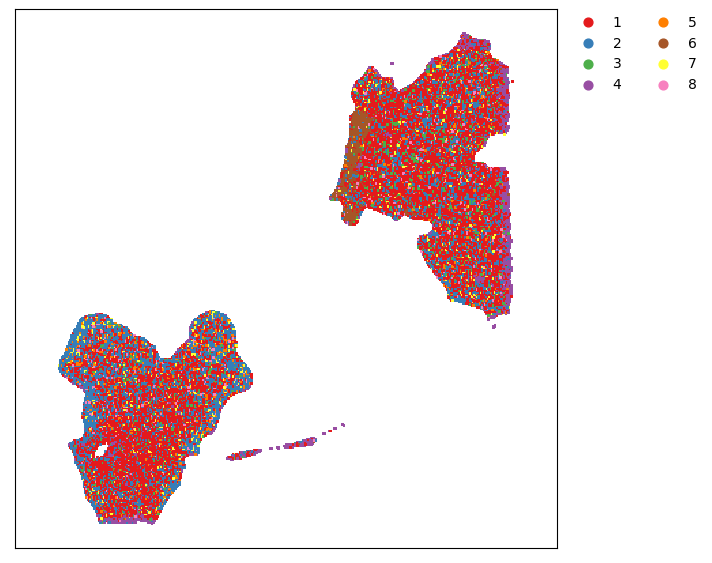

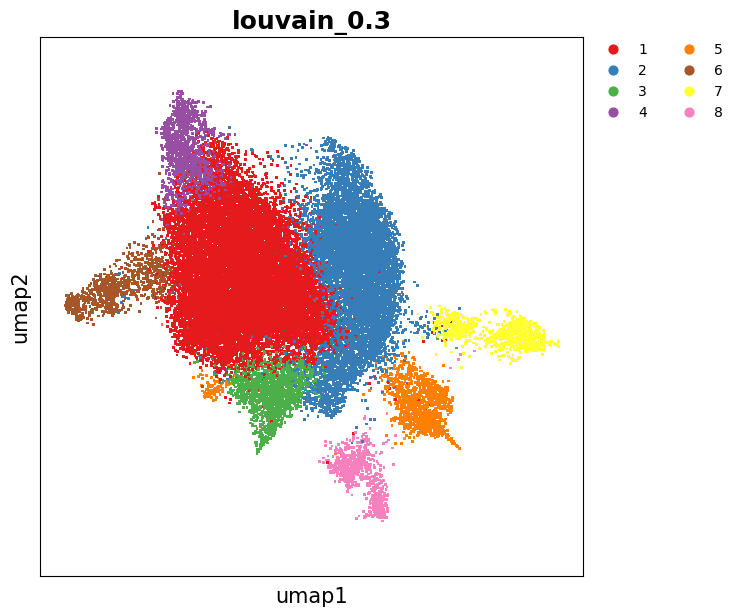

In [25]:
data.tl.louvain(neighbors_res_key='neighbors', res_key='louvain_0.3', resolution=0.3)
data.plt.cluster_scatter(res_key='louvain_0.3')
data.plt.umap(res_key='umap', cluster_key='louvain_0.3')

[2023-01-31 13:44:11][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run louvain...
[2023-01-31 13:44:11][Stereo][137620][140387773699904][_louvain][99][INFO]:     using the "louvain" package of Traag (2017)
[2023-01-31 13:44:15][Stereo][137620][140387773699904][st_pipeline][43][INFO]: louvain end, consume time 4.0350s.


<AxesSubplot:title={'center':'louvain_0.8'}, xlabel='umap1', ylabel='umap2'>

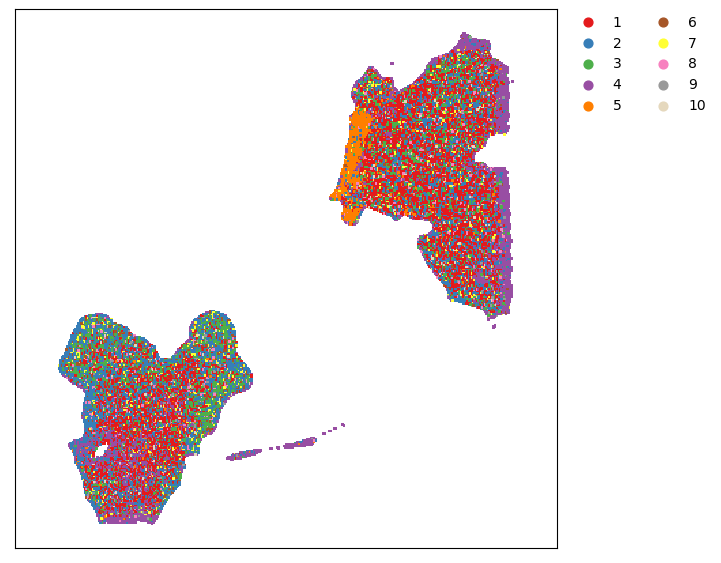

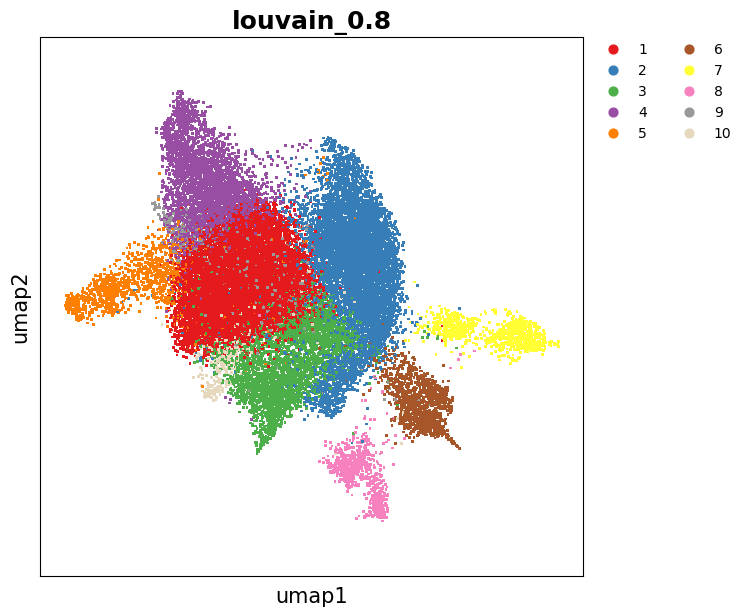

In [26]:
data.tl.louvain(neighbors_res_key='neighbors', res_key='louvain_0.8', resolution=0.8)
data.plt.cluster_scatter(res_key='louvain_0.8')
data.plt.umap(res_key='umap', cluster_key='louvain_0.8')

[2023-01-31 13:44:16][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run leiden...
[2023-01-31 13:44:23][Stereo][137620][140387773699904][st_pipeline][43][INFO]: leiden end, consume time 6.6235s.


<AxesSubplot:title={'center':'leiden_0.2'}, xlabel='umap1', ylabel='umap2'>

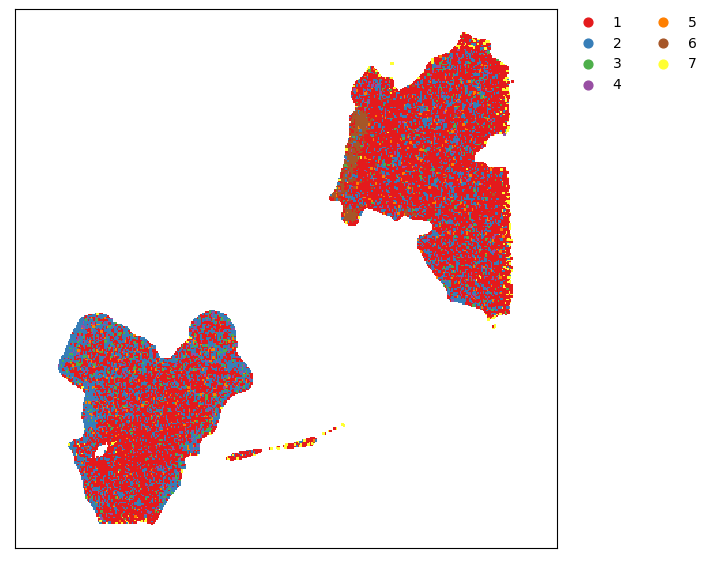

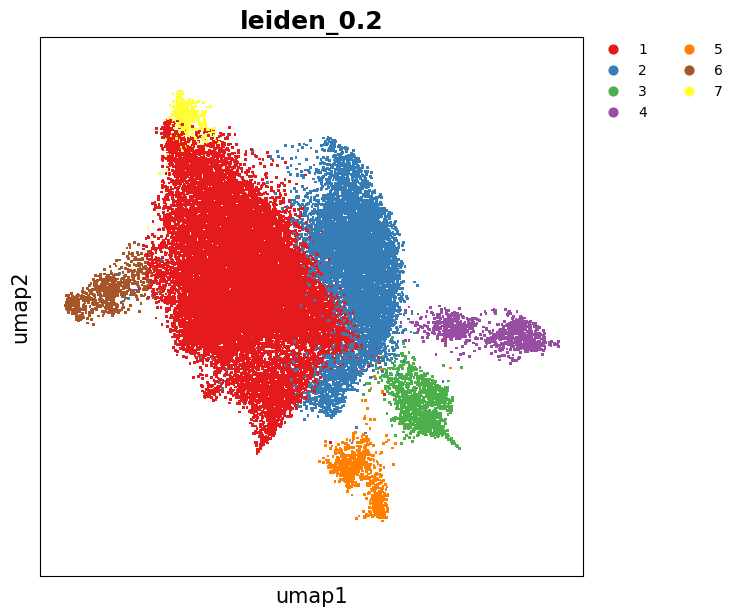

In [27]:
data.tl.leiden(neighbors_res_key='neighbors', res_key='leiden_0.2', resolution=0.2)
data.plt.cluster_scatter(res_key='leiden_0.2')
data.plt.umap(res_key='umap', cluster_key='leiden_0.2')

[2023-01-31 13:44:23][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run leiden...
[2023-01-31 13:44:28][Stereo][137620][140387773699904][st_pipeline][43][INFO]: leiden end, consume time 4.2601s.


<AxesSubplot:title={'center':'leiden_0.6'}, xlabel='umap1', ylabel='umap2'>

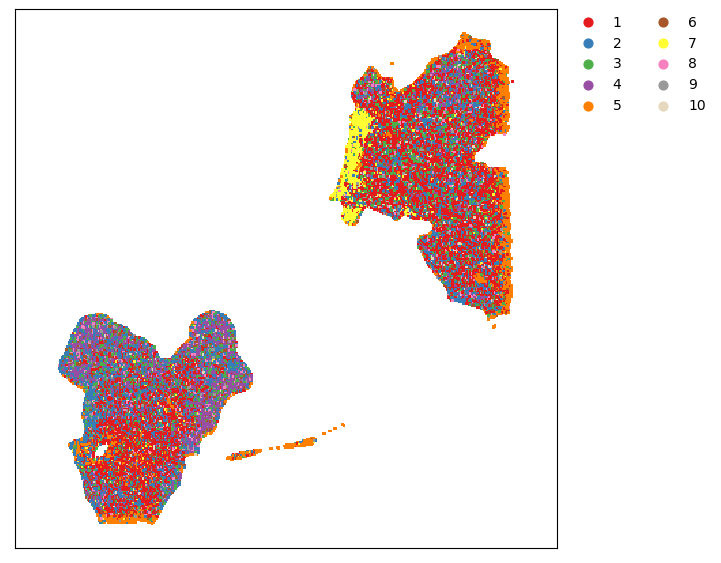

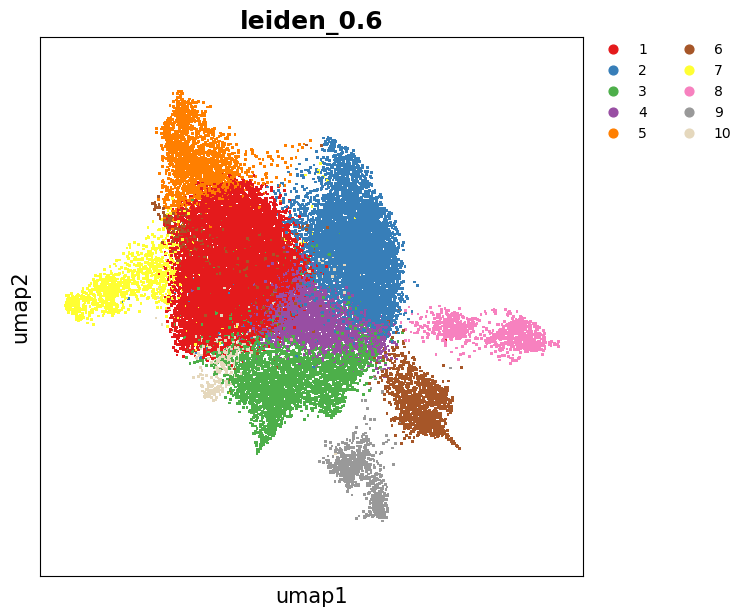

In [28]:
data.tl.leiden(neighbors_res_key='neighbors', res_key='leiden_0.6', resolution=0.6)
data.plt.cluster_scatter(res_key='leiden_0.6')
data.plt.umap(res_key='umap', cluster_key='leiden_0.6')

In [29]:
outkey_record = {'cluster':['leiden_0.2','leiden_0.6','louvain_0.3','louvain_0.8'],}
st.io.write_h5ad(data, use_raw=True, use_result=True, key_record=outkey_record, output='./849BL_A4.bin50.h5ad')

In [50]:
#data.tl.phenograph(phenograph_k=30, pca_res_key='pca', res_key='phenograph')
#data.plt.cluster_scatter(res_key='phenograph')
#data.plt.umap(res_key='umap', cluster_key='phenograph')

In [51]:
# data.tl.gaussian_smooth(n_neighbors=10, smooth_threshold=90 inplace=False, res_key="gs")
# data.tl.scale(max_value=10) #only for gaussian_smooth_scatter_by_gene

In [48]:
data.tl.find_marker_genes(cluster_res_key='louvain_0.3', method='t_test', use_highly_genes=False, use_raw=False, hvg_res_key="hvg_nt", 
                          res_key='marker_louvain_0.3', output="marker_gene/849BL_A4.louvain_0.3.marker_gene.csv")
data.tl.find_marker_genes(cluster_res_key='louvain_0.8', method='t_test', use_highly_genes=False, use_raw=False, hvg_res_key="hvg_nt", 
                          res_key='marker_louvain_0.8', output="marker_gene/849BL_A4.louvain_0.8.marker_gene.csv")
data.tl.find_marker_genes(cluster_res_key='leiden_0.2', method='t_test', use_highly_genes=False, use_raw=False, hvg_res_key="hvg_nt", 
                          res_key='marker_leiden_0.2', output="marker_gene/849BL_A4.leiden_0.2.marker_gene.csv")
data.tl.find_marker_genes(cluster_res_key='leiden_0.6', method='t_test', use_highly_genes=False, use_raw=False, hvg_res_key="hvg_nt", 
                          res_key='marker_leiden_0.6', output="marker_gene/849BL_A4.leiden_0.6.marker_gene.csv")

[2023-01-31 14:30:19][Stereo][137620][140387773699904][st_pipeline][40][INFO]: start to run find_marker_genes...
[2023-01-31 14:30:19][Stereo][137620][140387773699904][tool_base][117][INFO]: read group information, grouping by group column.
[2023-01-31 14:30:19][Stereo][137620][140387773699904][tool_base][155][INFO]: start to run...
Find marker gene:   0%|          | 0/8 [00:00<?, ?it/s][2023-01-31 14:30:19][Stereo][137620][140387773699904][find_markers][119][INFO]: start to select group
[2023-01-31 14:30:19][Stereo][137620][140387773699904][find_markers][122][INFO]: end selelct group
Find marker gene:  12%|█▎        | 1/8 [00:01<00:13,  1.89s/it][2023-01-31 14:30:20][Stereo][137620][140387773699904][find_markers][119][INFO]: start to select group
[2023-01-31 14:30:21][Stereo][137620][140387773699904][find_markers][122][INFO]: end selelct group
Find marker gene:  25%|██▌       | 2/8 [00:03<00:11,  1.87s/it][2023-01-31 14:30:22][Stereo][137620][140387773699904][find_markers][119][INFO]:

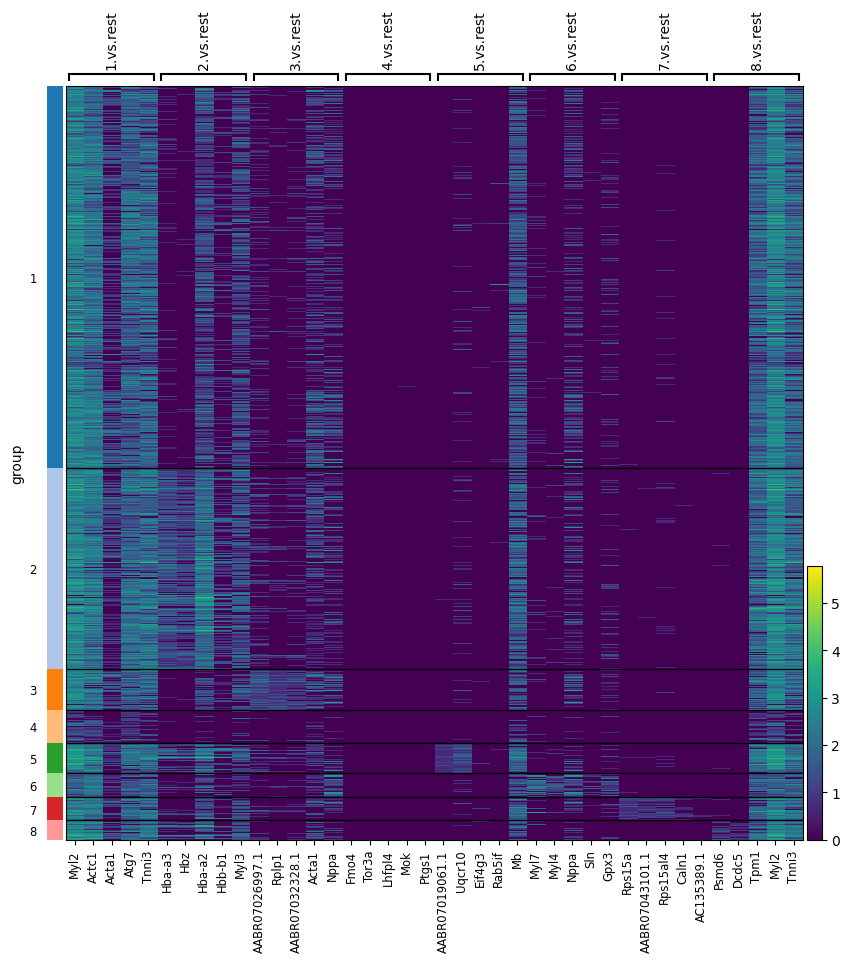

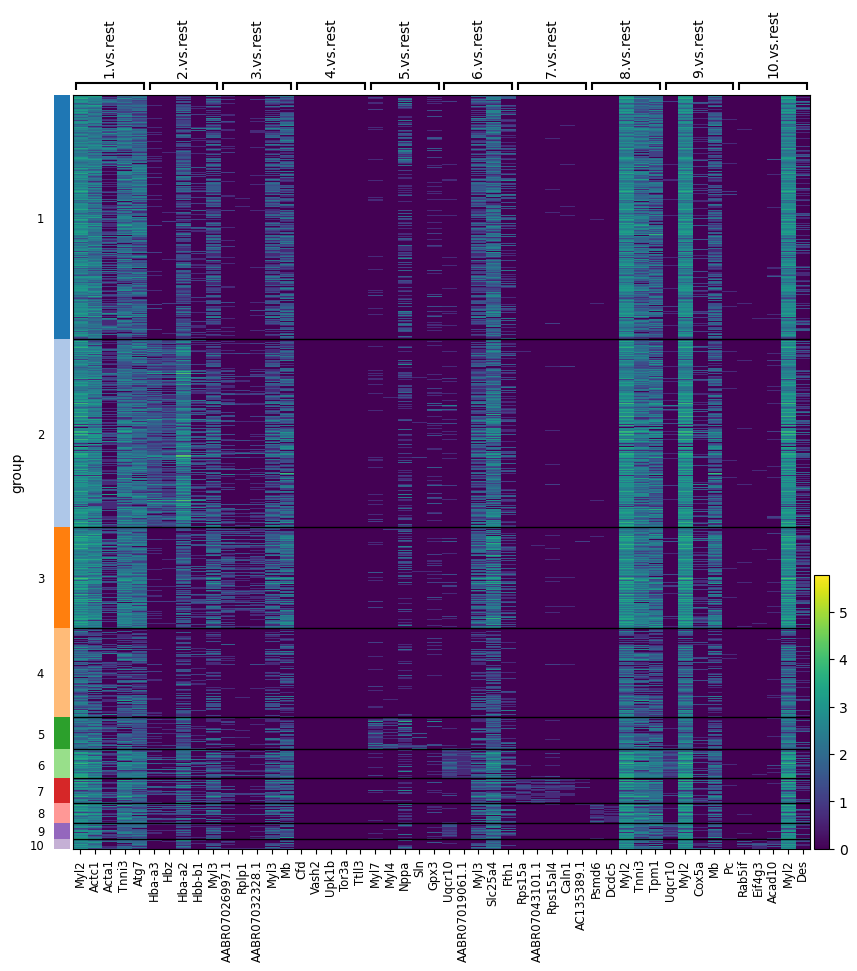

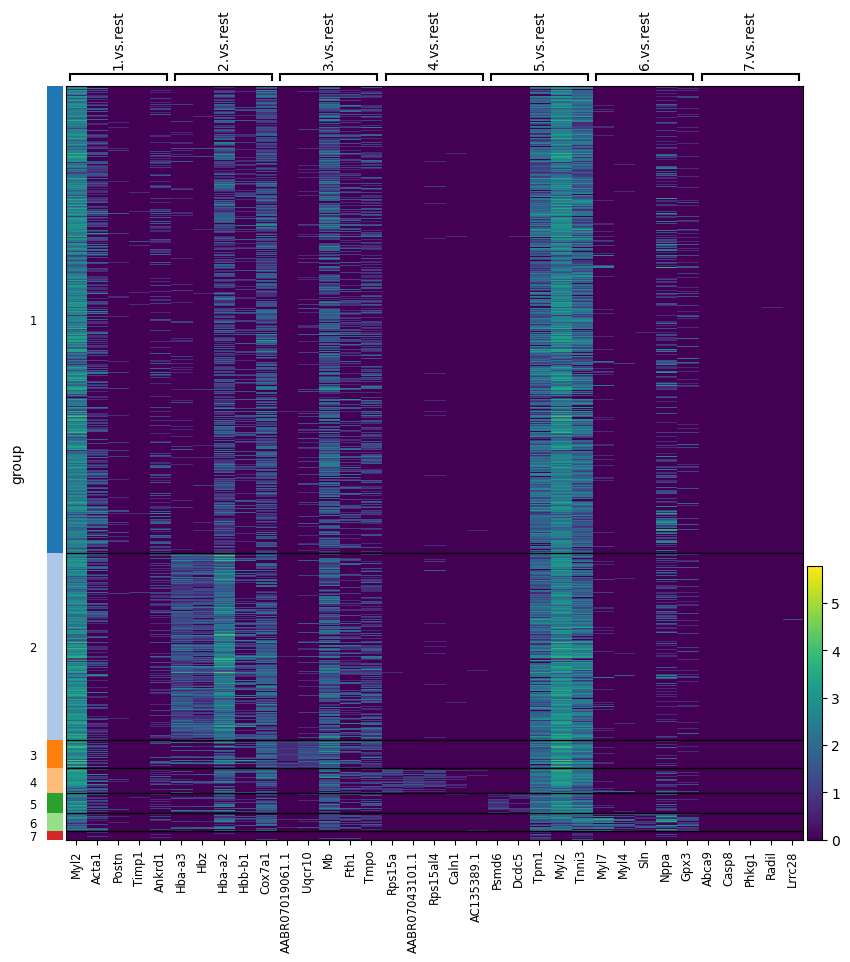

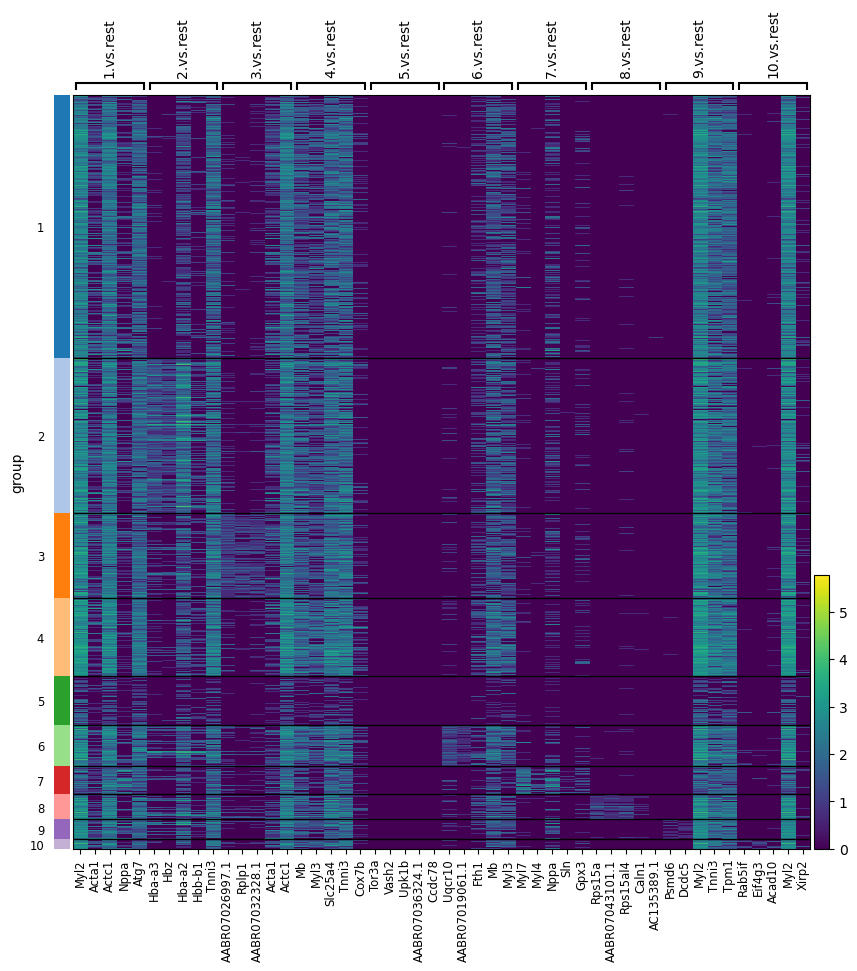

In [51]:
data.plt.marker_genes_heatmap(res_key='marker_louvain_0.3', cluster_res_key='louvain_0.3', markers_num=5, do_log=True)
data.plt.marker_genes_heatmap(res_key='marker_louvain_0.8', cluster_res_key='louvain_0.8', markers_num=5, do_log=True)
data.plt.marker_genes_heatmap(res_key='marker_leiden_0.2', cluster_res_key='leiden_0.2', markers_num=5, do_log=True)
data.plt.marker_genes_heatmap(res_key='marker_leiden_0.6', cluster_res_key='leiden_0.6', markers_num=5, do_log=True)

In [50]:
st.plots.marker_genes_text(marker_res='marker_louvain_0.3', groups ='louvain_0.3', markers_num=5, sort_key="1_scores")

TypeError: string indices must be integers

<Figure size 1000x1000 with 0 Axes>

In [ ]:
st.io.write_mid_gef(data=data, output='/scratch/u/qqiu/project/multiomics/stereo_seq/result/stereopy/SS200000849BL_A4.bin50.filter.gef')

In [43]:
marker_list = ['Nphs1', 'Ncam1', 'Slc34a1', 'Slc7a12', 
                'Havcr1', 'Fst', 'Atp10b', 'Slc12a1', 'Nos1',
                'Slc12a3', 'Slc8a1', 'Aqp2', 'Kit', 'Slc26a4',
                'Flt1', 'Ren1', 'Ptprc']
marker_list_use = [i for i in marker_list if i in data.gene_names]

fig = data.plt.umap(gene_names=marker_list_use, res_key='umap')

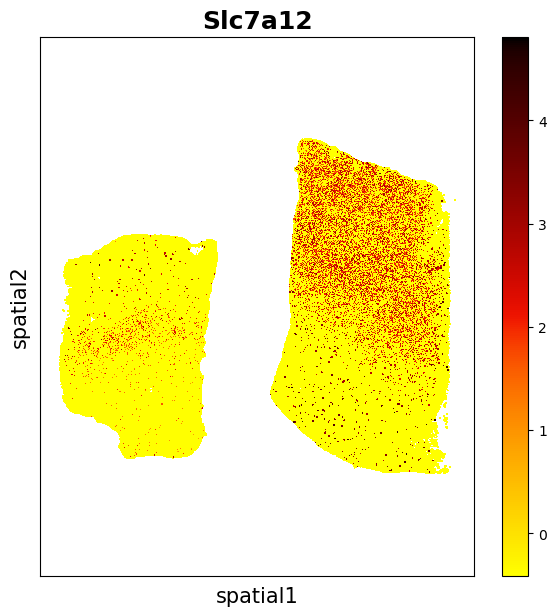

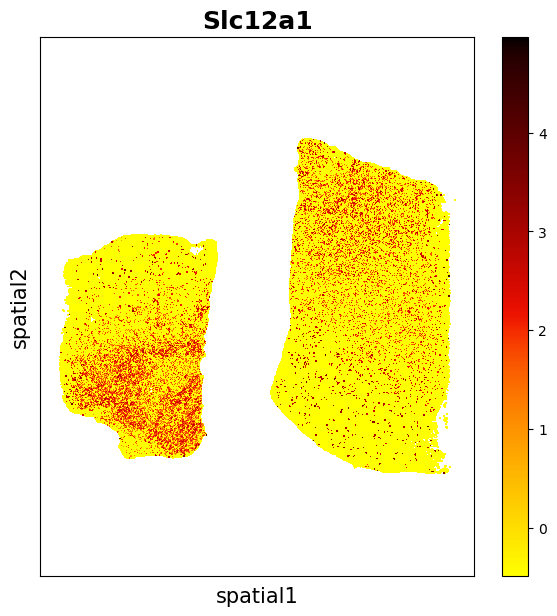

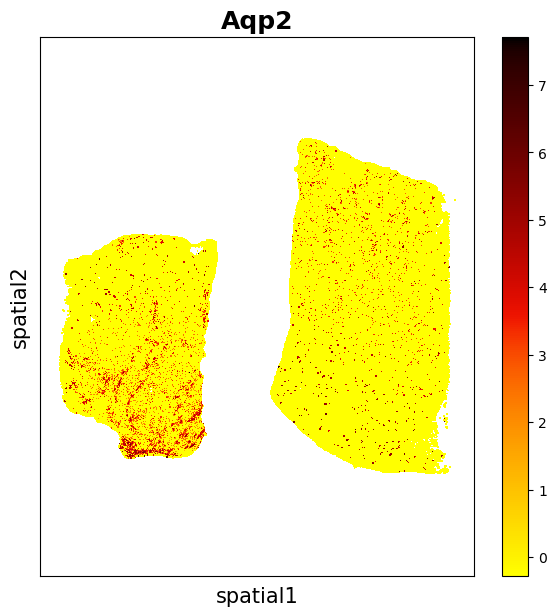

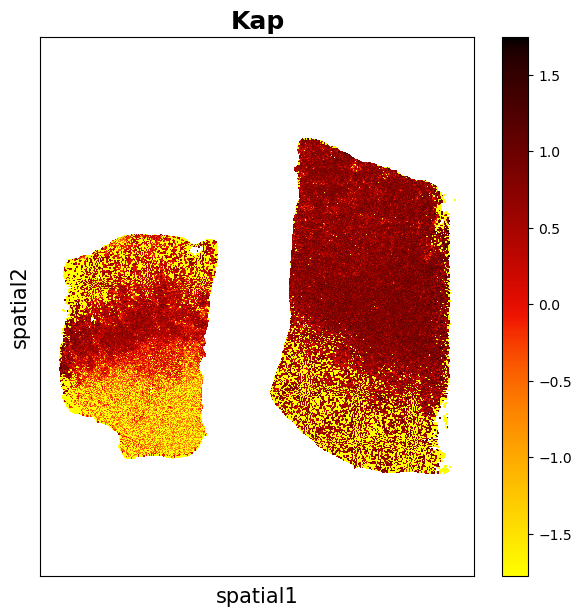

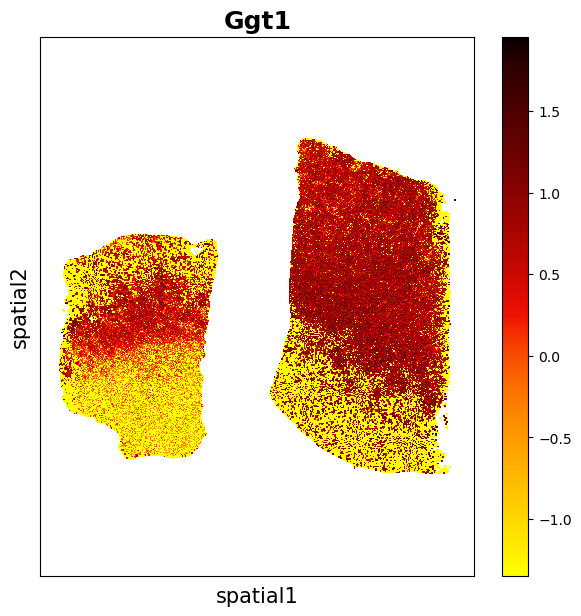

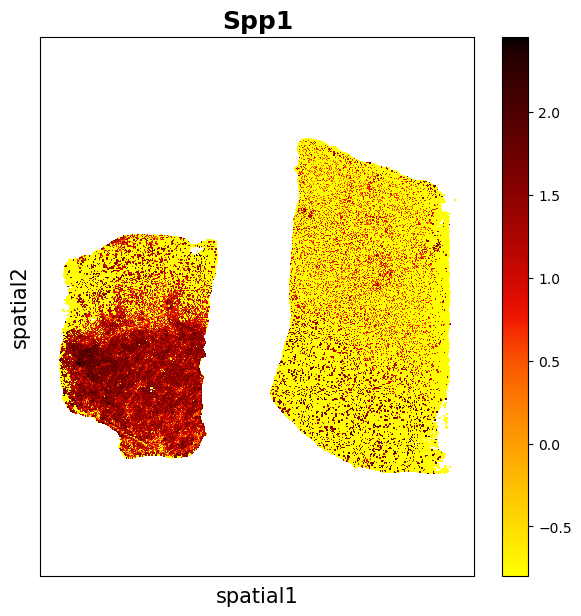

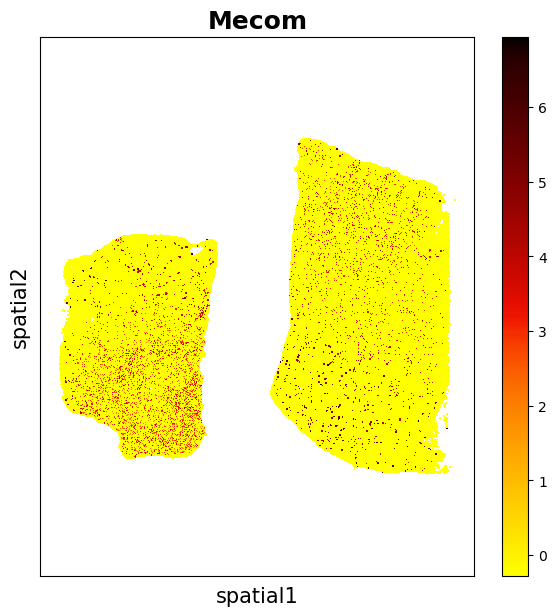

In [56]:
data.plt.spatial_scatter_by_gene(gene_name='Slc7a12')
data.plt.spatial_scatter_by_gene(gene_name='Slc12a1')
data.plt.spatial_scatter_by_gene(gene_name='Aqp2')
data.plt.spatial_scatter_by_gene(gene_name='Kap')
data.plt.spatial_scatter_by_gene(gene_name='Ggt1')
data.plt.spatial_scatter_by_gene(gene_name='Spp1')
data.plt.spatial_scatter_by_gene(gene_name='Mecom')